# 딥러닝 모델 정리

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# cd /content/drive/MyDrive/Colab Notebooks/법령프로젝트

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. 데이터 불러오기

In [5]:
df = pd.read_csv('BaseTable3.csv')
df.info()

/var/folders/zr/_f1rgf8n0w3541q9k8p3smhr0000gn/T/ipykernel_99576/3148388814.py:1: DtypeWarning: Columns (5,6,14,17,18,19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('BaseTable3.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861621 entries, 0 to 861620
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  861621 non-null  int64  
 1   소관부처명       861621 non-null  object 
 2   법령명         861621 non-null  object 
 3   법령구분        861621 non-null  int64  
 4   조번호         861040 non-null  object 
 5   항번호         666508 non-null  object 
 6   호번호         504872 non-null  object 
 7   조문제목        861621 non-null  object 
 8   조문          861621 non-null  object 
 9   사무판단        861621 non-null  int64  
 10  사무판단근거      700807 non-null  object 
 11  사무명         60065 non-null   object 
 12  수행주체        60066 non-null   object 
 13  사무유형        60023 non-null   object 
 14  위임사무판단      761041 non-null  object 
 15  위임근거규정      5290 non-null    object 
 16  수임기관        4396 non-null    object 
 17  특행기관        93064 non-null   object 
 18  재위임사무판단     702423 non-null  object 
 19  재위

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')    # GPU 사용
device

device(type='cpu')

## 1) [조문, 사무판단] 추출

In [7]:
sub_df = df.loc[df['사무판단']!=2, ["조문", "사무판단"]]
sub_df

,조문,사무판단
0,제1장 총칙,0
1,제1조(목적) 이 법은 개인정보의 처리 및 보호에 관한 사항을 정함으로써 개인의 자...,0
2,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2014.3.2...,0
3,"1. ""개인정보""란 살아 있는 개인에 관한 정보로서 다음 각 목의 어느 하나에 해당...",0
4,"1의2. ""가명처리""란 개인정보의 일부를 삭제하거나 일부 또는 전부를 대체하는 등의...",0
...,...,...
861616,1. 한국수자원공사,0
861617,2. 법 제56조에 따른 한국상하수도협회,0
861618,제32조(규제의 재검토) 환경부장관은 다음 각 호의 사항에 대하여 다음 각 호의 기...,0
861619,1. 제23조의2제1항ㆍ제4항 및 별표 7의2에 따른 저수조청소업의 인력ㆍ시설 및 ...,0


In [8]:
#sub_df.to_csv('sub_df.csv')      # 임시 저장

# 2. 데이터 분리
* label이 모집단과 동일한 비율로 분리되도록 설정

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit을 사용하여 데이터를 분리
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in stratified_splitter.split(sub_df['조문'], sub_df['사무판단']):
    train_df = sub_df.iloc[train_index]
    val_df = sub_df.iloc[val_index]

In [10]:
t_count = train_df['사무판단'].value_counts()
v_count = val_df['사무판단'].value_counts()

print(f"train 데이터 사무비율: {t_count[0]/sum(t_count)}")
print(f"val 데이터 사무비율: {v_count[0]/sum(v_count)}")

train 데이터 사무비율: 0.9303376198324087
val 데이터 사무비율: 0.9303351225881329


# 3. 모델 구현
* 2 layer 인공신경망: 512 -> 128 -> 2
* 배치정규화, relu적용

## 1) 모델 정의

In [11]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)  
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # 모델의 forward 계산 로직
        x = self.layer1(input_ids.float())
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.layer2(x)

        return x

In [12]:
# 모델 및 토크나이저 불러오기
model_name = 'klue/roberta-large'
#model = AutoModelForSequenceClassification.from_pretrained(model_name)   # gpu부족으로 제한
tokenizer = AutoTokenizer.from_pretrained(model_name)

input_size = 512
hidden_size = 128
output_size = 2

model = MyModel(input_size, hidden_size, output_size)

## 2) 입력 데이터셋 정리
* 512 차원으로 padding 진행
* batch size = 16

In [13]:
# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['조문']
        label = torch.tensor(self.data.iloc[idx]['사무판단'], dtype=torch.long)
        tokenized_data = tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors='pt')
        return {'input_ids': tokenized_data['input_ids'].squeeze(),
                'attention_mask': tokenized_data['attention_mask'].squeeze(),
                'labels': label}


In [14]:
# 각 배치의 텍스트 길이를 맞추기
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # 패딩
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': torch.stack(labels)}

In [15]:
# 데이터로더 생성
batch_size = 16  # 배치크기 조절

train_dataset = CustomDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = CustomDataset(val_df, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [16]:
val_dataset

In [17]:
# 모델을 GPU로 이동  -> 작은 신경망이라 cpu로 돌림
#model.to(device)

## 3) 튜닝 파라미터 지정
* optimizer: Adam
* learning rate: 1e-5

In [18]:
# 나머지 파라미터 정리
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/Users/ihongju/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4) 모델 학습

In [19]:
# 손실 기록을 위한 리스트
train_losses = []
val_losses = []

In [20]:
from sklearn.metrics import recall_score

# 클래스 0에 대한 적절한 가중치를 계산 (imbalance data 고려)
class_0_weight = 0.06
class_1_weight = 1.0

class_weights = [class_0_weight, class_1_weight]    # 0, 1의 가중치를 차등 부여

# 학습 루프에서 'labels'를 사용하는 부분 수정
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        logits = model(**inputs)
        if logits.dtype != torch.float32:
            logits = logits.float()
        loss = torch.nn.functional.cross_entropy(logits, labels, weight=torch.Tensor(class_weights).to(device))
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss}')

    model.eval()
    val_loss = 0.0
    y_true = []  # 실제 레이블을 저장할 리스트
    y_pred = []  # 모델의 예측 결과를 저장할 리스트
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # 모델에 토큰화된 입력 데이터 전달
            outputs = model(**inputs)
            if outputs.dtype != torch.float32:
                outputs = outputs.float()

            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            val_loss += torch.nn.functional.cross_entropy(outputs, labels, weight=torch.Tensor(class_weights).to(device))

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}')
    # Calculate Recall
    recall = recall_score(y_true, y_pred, average='weighted')  # 'weighted'는 각 클래스의 샘플 수에 따라 가중 평균을 계산합니다.
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Recall: {recall}')

Epoch 1/5 - Training: 100%|██████████████| 43081/43081 [03:14<00:00, 221.63it/s]


Epoch 1/5, Average Training Loss: 0.5239665991301568


Epoch 1/5 - Validation: 100%|████████████| 10771/10771 [00:40<00:00, 264.66it/s]


Epoch 1/5, Validation Loss: 0.4939045310020447
Epoch 1/5, Validation Recall: 0.7724125924851298


Epoch 2/5 - Training: 100%|██████████████| 43081/43081 [03:13<00:00, 222.08it/s]


Epoch 2/5, Average Training Loss: 0.4985668318130958


Epoch 2/5 - Validation: 100%|████████████| 10771/10771 [00:40<00:00, 268.15it/s]


Epoch 2/5, Validation Loss: 0.48241615295410156
Epoch 2/5, Validation Recall: 0.7729754823734223


Epoch 3/5 - Training: 100%|██████████████| 43081/43081 [03:11<00:00, 224.61it/s]


Epoch 3/5, Average Training Loss: 0.4890418174231894


Epoch 3/5 - Validation: 100%|████████████| 10771/10771 [00:40<00:00, 264.87it/s]


Epoch 3/5, Validation Loss: 0.4739820957183838
Epoch 3/5, Validation Recall: 0.7625475119686639


Epoch 4/5 - Training: 100%|██████████████| 43081/43081 [03:12<00:00, 223.36it/s]


Epoch 4/5, Average Training Loss: 0.4844063688010349


Epoch 4/5 - Validation: 100%|████████████| 10771/10771 [00:41<00:00, 257.78it/s]


Epoch 4/5, Validation Loss: 0.47453540563583374
Epoch 4/5, Validation Recall: 0.7842100681851153


Epoch 5/5 - Training: 100%|██████████████| 43081/43081 [03:12<00:00, 223.52it/s]


Epoch 5/5, Average Training Loss: 0.48282361713480765


Epoch 5/5 - Validation: 100%|████████████| 10771/10771 [00:40<00:00, 266.81it/s]


Epoch 5/5, Validation Loss: 0.46963998675346375
Epoch 5/5, Validation Recall: 0.7725982881183809


## 1) loss 그래프

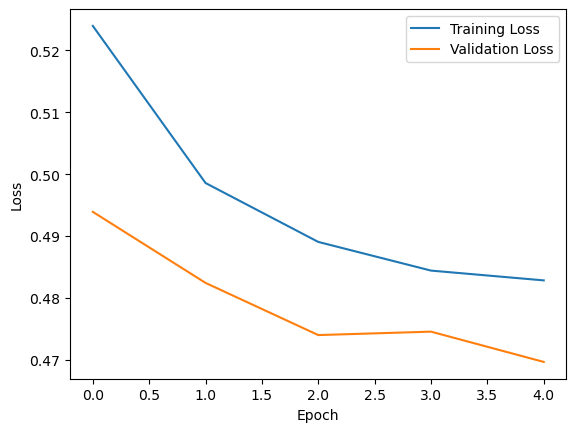

In [21]:
# 손실 값 시각화
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5 모델 평가

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

model.eval()
val_loss = 0.0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc=f'Validation'):
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        # 모델에 토큰화된 입력 데이터 전달
        outputs = model(**inputs)
        if outputs.dtype != torch.float32:
            outputs = outputs.float()
        val_loss += torch.nn.functional.cross_entropy(outputs, labels.long())
        
        # 소프트맥스를 적용하여 확률값 얻기
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
        
        # 예측값과 정답을 리스트에 추가
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 손실 계산
avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)


Validation: 100%|████████████████████████| 10771/10771 [00:40<00:00, 265.79it/s]


## 1) 결과 확인

In [29]:
prob = [sublist[1] for sublist in all_probs]

In [30]:
# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    'True_Labels': all_labels,
    'Predictions': all_preds,
    'Probability_1': prob
})

result_df

,True_Labels,Predictions,Probability_1
0,0,0,0.026727
1,0,0,0.097768
2,0,0,0.036723
3,0,0,0.353132
4,0,1,0.520629
...,...,...,...
172320,0,0,0.008365
172321,0,1,0.508366
172322,0,0,0.012416
172323,1,1,0.578635


In [31]:
#result_df.to_csv('epo5_result_df.csv')   # 결과 저장

In [32]:
#torch.save(model.state_dict(), "model_06_1_5.pth")    # 모델 저장

## 2) 결과 통계량 확인

In [33]:
result_df.loc[result_df['Predictions']==0, ].describe()

,True_Labels,Predictions,Probability_1
count,127067.000000,127067.0,127067.000000
mean,0.023350,0.0,0.152123
std,0.151013,0.0,0.154932
min,0.000000,0.0,0.002187
25%,0.000000,0.0,0.023082
50%,0.000000,0.0,0.070822
75%,0.000000,0.0,0.275795
max,1.000000,0.0,0.499992


In [34]:
result_df.loc[result_df['Predictions']==1, ].describe()

,True_Labels,Predictions,Probability_1
count,45258.000000,45258.0,45258.000000
mean,0.199700,1.0,0.653751
std,0.399779,0.0,0.096457
min,0.000000,1.0,0.500006
25%,0.000000,1.0,0.573960
50%,0.000000,1.0,0.645236
75%,0.000000,1.0,0.723073
max,1.000000,1.0,0.965777


## 3) ROC 커브 확인

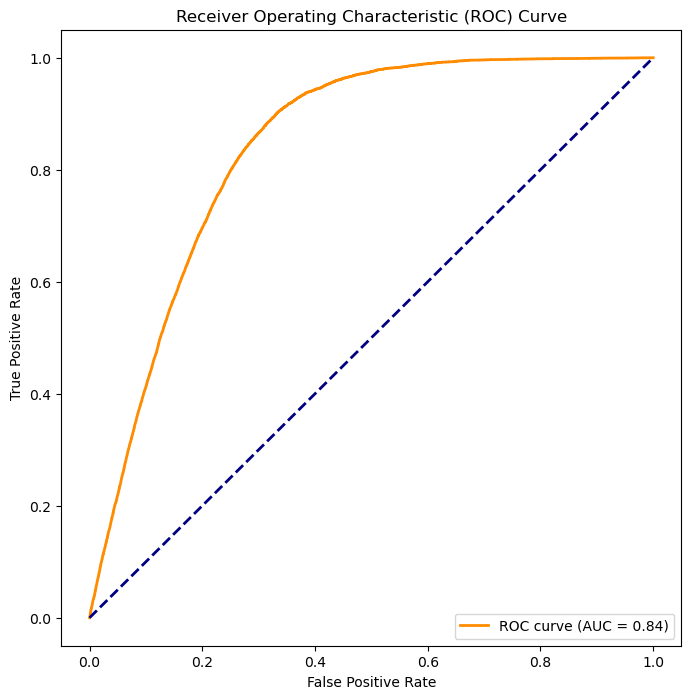

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(result_df['True_Labels'], result_df['Probability_1'])
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

* 디폴트 threshold 기준 평가 지표 확인

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# confusion matrix, accuracy, precision, recall, f1-score 계산
conf_matrix = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# 디폴트 결과 출력
print(f"Avg Validation Loss: {avg_val_loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Avg Validation Loss: 0.39846527576446533
Accuracy: 0.7725982881183809
Precision: 0.1996995006407707
Recall: 0.7528529779258643
F1-Score: 0.31566631157990327
Confusion Matrix:
[[124100  36220]
 [  2967   9038]]


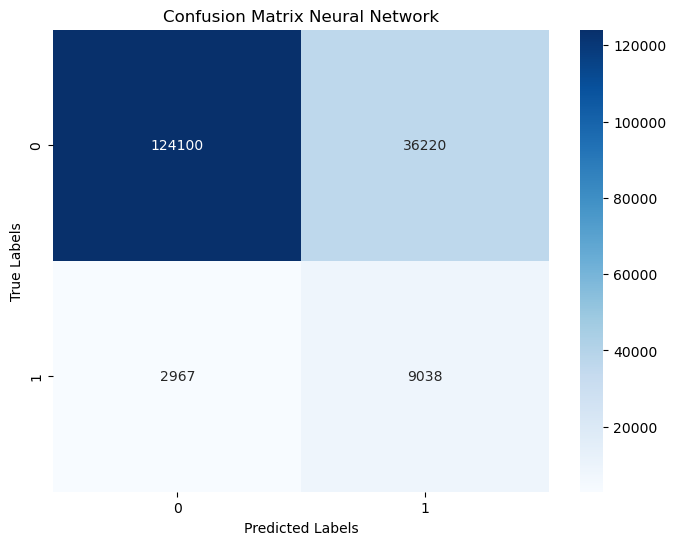

In [37]:
import seaborn as sns

# seaborn을 사용하여 heatmap으로 confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix Neural Network')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 4) threshold 조절

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def cal_result(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    
    return accuracy, recall

In [39]:
x = np.arange(0.15, 0.29, 0.01).tolist()
y_acc = []
y_rec = []

for i in x:
    threshold = i
    result_df['new_predictions'] = 0
    result_df.loc[result_df['Probability_1']>threshold, 'new_predictions'] = 1
    acc, rec = cal_result(result_df['new_predictions'], result_df['True_Labels'])
    y_acc.append(acc)
    y_rec.append(rec)

- threshold에 따른 accuracy, recall 그래프 확인

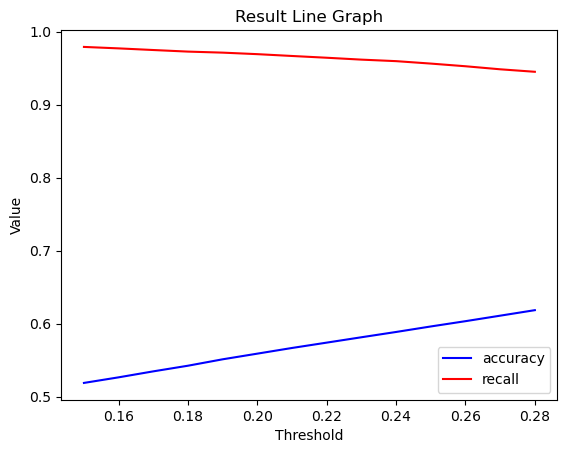

In [40]:
import matplotlib.pyplot as plt

# accuracy 그래프
plt.plot(x, y_acc, label='accuracy', color='blue')

# recall 그래프
plt.plot(x, y_rec, label='recall', color='red')

# 그래프에 제목과 축 레이블 추가
plt.title('Result Line Graph')
plt.xlabel('Threshold')
plt.ylabel('Value')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

In [41]:
print(f"accuracy 최대값: {y_acc[-1]}, 최소값: {y_acc[0]}")
print(f"recall 최소값: {y_rec[-1]}, 최대값: {y_rec[0]}")

accuracy 최대값: 0.6184186856230959, 최소값: 0.5187291455099377
recall 최소값: 0.9450229071220325, 최대값: 0.9790920449812578


* prediction 중위수, 3분위수에 따른 결과 모두 출력

In [42]:
def cal_result2(preds, y):
    conf_matrix = confusion_matrix(y, preds)
    accuracy = accuracy_score(y, preds)
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    f1 = f1_score(y, preds)
    
    # 결과 출력
    print(f"Avg Validation Loss: {avg_val_loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    return conf_matrix

# prediction 중위수
print('======threshold = 0.16======')
threshold = 0.16
result_df['new_predictions'] = 0
result_df.loc[result_df['Probability_1']>threshold, 'new_predictions'] = 1
a = cal_result2(result_df['new_predictions'], result_df['True_Labels'])

# prediction 3분위수
print('======threshold = 0.28======')
threshold = 0.28
result_df['new_predictions'] = 0
result_df.loc[result_df['Probability_1']>threshold, 'new_predictions'] = 1
b = cal_result2(result_df['new_predictions'], result_df['True_Labels'])

======threshold = 0.16======
Avg Validation Loss: 0.39846527576446533
Accuracy: 0.5263890903815465
Precision: 0.1260341678306651
Recall: 0.9770928779675135
F1-Score: 0.22326909350463958
Confusion Matrix:
[[78980 81340]
 [  275 11730]]
======threshold = 0.28======
Avg Validation Loss: 0.39846527576446533
Accuracy: 0.6184186856230959
Precision: 0.14841511754163342
Recall: 0.9450229071220325
F1-Score: 0.25654071410804336
Confusion Matrix:
[[95224 65096]
 [  660 11345]]


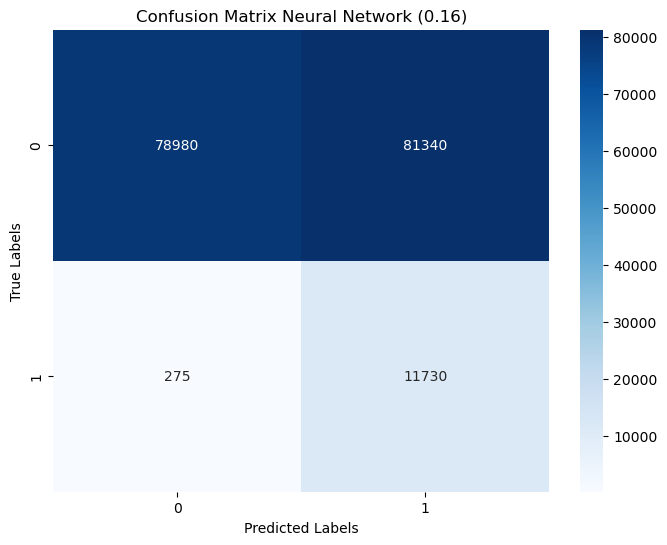

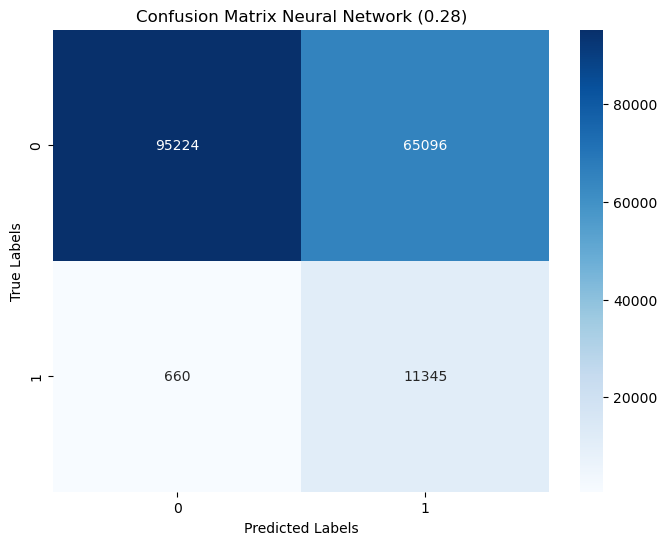

In [43]:
# seaborn을 사용하여 heatmap으로 confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(a, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix Neural Network (0.16)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(b, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix Neural Network (0.28)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()